In [1]:
%%bash
pip install pillow numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━��━━━━━━━━━━━━━━━ 5.1/5.1 MB 37.5 MB/s eta 0:00:00


In [3]:
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# -------- paths --------
SRC          = Path("~/Downloads/procell1.jpg").expanduser()   # original collage
OUT          = Path("skin_before_after_captioned.jpg")            # final result

# --------------------------------------------------------------------
# 1) LOAD IMAGE & FIND THE Two photo REGIONS (simple threshold + split)
# --------------------------------------------------------------------
img  = Image.open(SRC)
gray = img.convert("L")                     # grayscale makes threshold easy
arr  = np.array(gray)
print(f"Image size is {arr.shape}")
mask = arr < 240                            # “not-white” ≈ photo content

ys, xs = np.where(mask)
mid_y  = (ys.min() + ys.max()) // 2         # halfway down the collage

# restrict search to the right half where the photos live
x_lo, x_hi = 480, 820                       # tweak if your source differs

top_idx = (ys < mid_y)  & (xs > x_lo) & (xs < x_hi)
bot_idx = (ys >= mid_y) & (xs > x_lo) & (xs < x_hi)

def bbox(idx):
    y, x = ys[idx], xs[idx]
    return (x.min() + 10, y.min() + 10, x.max() - 10, y.max() - 10)

before_box = bbox(top_idx)
after_box  = bbox(bot_idx)

before_img = img.crop(before_box)
after_img  = img.crop(after_box)

Image size is (1280, 1024)


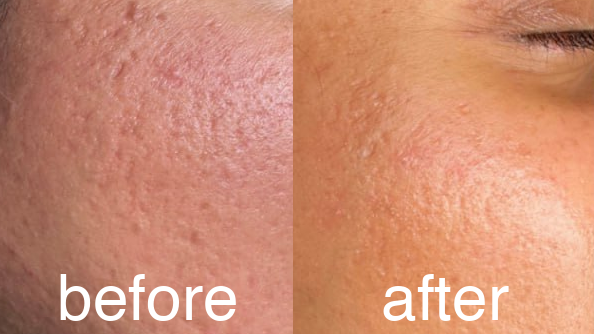

In [32]:
# ------------------------------------
# 2) STITCH PHOTOS SIDE-BY-SIDE (no text)
# ------------------------------------
canvas_w = before_img.width + after_img.width
canvas_h = min(before_img.height, after_img.height)
canvas_h = canvas_w * 9 // 16
offset = (canvas_h - min(before_img.height, after_img.height)) // 2
side = Image.new("RGB", (canvas_w, canvas_h), "white")
side.paste(before_img, (0, offset))
side.paste(after_img,  (before_img.width, offset))

# ----------------------------------------
# 3) ADD “BEFORE” / “AFTER” CAPTIONS BELOW
# ----------------------------------------
CAPTION_H  = 0     # extra vertical space
FONT_SIZE  = 64
FONT_PATH  = "/System/Library/Fonts/Helvetica.ttc"     # change to any TTF on your system

canvas = Image.new("RGB", (canvas_w, canvas_h + CAPTION_H), "white")
canvas.paste(side, (0, 0))

draw = ImageDraw.Draw(canvas)
font = ImageFont.truetype(FONT_PATH, FONT_SIZE)

y_text  = canvas_h + (CAPTION_H - FONT_SIZE) // 2
draw.text((canvas_w // 4,       y_text), "before", anchor="mm", font=font, fill="white")
draw.text((canvas_w * 3 // 4,   y_text), "after",  anchor="mm", font=font, fill="white")

canvas

In [33]:
canvas.save(OUT)
print("Done →", OUT.resolve())

Done → /Users/peterdemin/seattle-beauty-lounge/jigs/sbs/skin_before_after_captioned.jpg
